<a href="https://colab.research.google.com/github/Pakopac/Monkey_Species_CNN/blob/master/MonkeySpecies.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monkey Species Recognition CNN

Welcome in this notebook of the project ML recognition monkey species. \
Here we will describe step by step how to build a CNN model to a make a prediction of a specie of monkey from an image. \

## Setup

First we need to import the librairies needed. 

In [37]:
# Utils
import sys
import os
import shutil
import time
import pickle
import numpy as np
import h5py
import pandas as pd
import seaborn as sns

# Deep Learning Librairies
import tensorflow as tf
import keras.preprocessing.image as kpi
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as k
import keras.models as km
import keras.applications as ka

# Data Visualization
from matplotlib import pyplot as plt

In [38]:
# GPU mode for colab notebook
from tensorflow.python.client import device_lib
MODE = "GPU" if "GPU" in [k.device_type for k in device_lib.list_local_devices()] else "CPU"

I'm importing datas from my drive, I got the datas here: https://www.kaggle.com/slothkong/10-monkey-species

In [39]:
from google.colab import drive
drive.mount('/content/drive')
data_dir = '/content/drive/MyDrive/Colab_Notebooks/monkey/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Define Arrays with labels, types and some test images

In [ ]:
test_labels = ["n0", "n1", "n2", "n3", "n4", "n5", "n6", "n7", "n8", "n9"]
test_images = [
    "https://projectzerofootprint.com/wp-content/uploads/2016/08/monkey-2-1080x768.jpg",
    "https://i.ytimg.com/vi/Ptisy32iRRA/hqdefault.jpg",
    "https://images.pond5.com/red-uakari-monkey-footage-064800523_iconl.jpeg",
    "https://thejapanalps.com/wp-content/uploads/2020/03/nihonsaru01.jpg",
    "https://www.zoo-leipzig.de/fileadmin/_processed_/e/c/csm_Weissbauch-Zwergseidenaeffchen_3_c46c37b6a1.jpg",
    "https://cdn.britannica.com/05/181805-050-C9682415/capuchin-monkey.jpg",
    "https://www.neprimateconservancy.org/uploads/1/5/3/8/15380094/silvery-marmoset-istock-153473655-resize_45.jpg",
    "https://study.com/cimages/multimages/16/squirrel_monkeys.png",
    "https://ars.els-cdn.com/content/image/3-s2.0-B9780124095274000171-f17-04-9780124095274.jpg",
    "https://media-cdn.tripadvisor.com/media/photo-s/0a/67/93/f5/nilgiri-langur-karunkorangu.jpg"
]
monkey_species_type = ["Mantled Howler","Patas Monkey","Bald Uakari",
                        "Japanese Macaque","Pygmy Marmoset","White Headed Capuchin",
                        "Silvery Marmoset","Ommon Squirrel Monkey",
                        "Black Headed Night Monkey","Nilgiri Langur"]

Define hyperparameters here.

In [40]:
# Number trained/test images for model
N_train = 200
N_val = 80
# Image size for model
img_width = 150
img_height = 150
# Number of time iterate
epochs = 10
batch_size = 4

Informations per species are listed in monkey_labels.txt with the label, the names, the number of train images and the number of validations images

## EDA / Preprocessing

In [5]:
# We define columns and display as a pandas dataframe
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
df = pd.read_csv(data_dir + "monkey_labels.txt", names=cols, skiprows=1)
df

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


We can check the proportion of images of each species as a diagram. \
We have about the same values, in train we have between 130 and 150 images of each and in test we have between 25 and 30 images

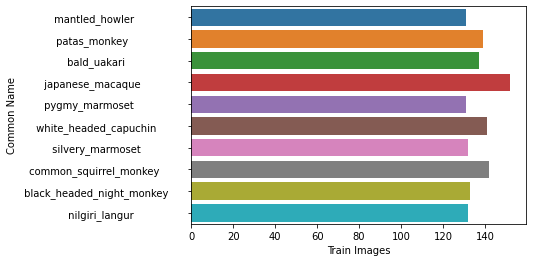

In [6]:
sns.barplot(x = df["Train Images"], y = df["Common Name"])
plt.show()

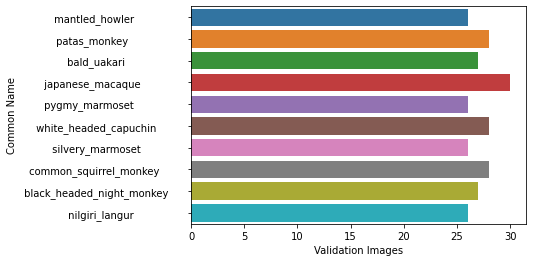

In [7]:
sns.barplot(x = df["Validation Images"], y = df["Common Name"])
plt.show()

We can load an image with kpi.load_image and convert to an array to test the render of image

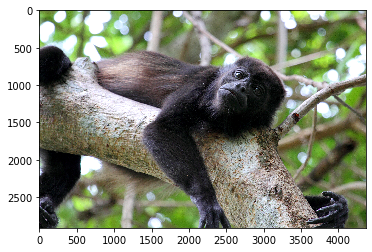

In [8]:
img = kpi.load_img(data_dir+'training/training/n0/n0021.jpg')
# Convert as array to show with pyplot
x = kpi.img_to_array(img)  
plt.imshow(x/255, interpolation='nearest')
plt.show()

Display one image of each

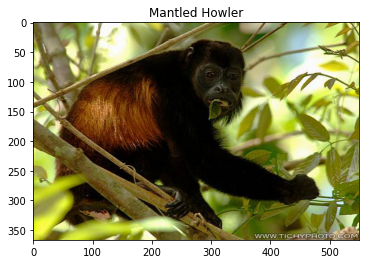

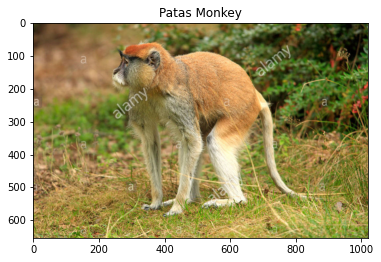

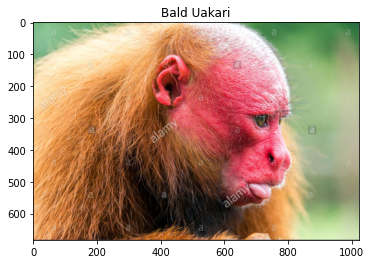

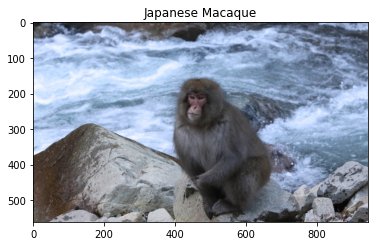

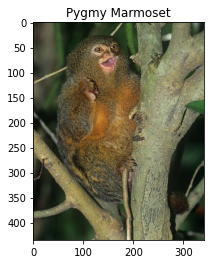

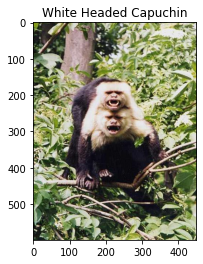

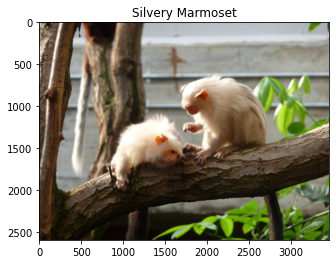

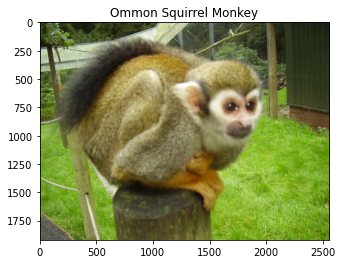

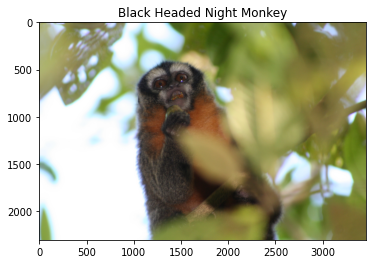

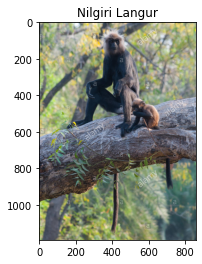

In [26]:
# Get first image of each directory in training and display with pyplot
for (i,label) in enumerate(test_labels):
  response = data_dir + "training/training/" + label +  "/" + os.listdir(data_dir + "training/training/" + label)[0]
  img = Image.open(response)
  image = tf.keras.utils.img_to_array(img.resize((224, 224)))
  image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
  plt.title(monkey_speciets_type[i])
  plt.imshow(img)
  plt.show()

## Model

Define train and test generator for model

In [44]:
# data augmentation on train (zoom, rotate, rescale...)
train_datagen = kpi.ImageDataGenerator(
    rotation_range = 30,
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = kpi.ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    data_dir + 'training/training',
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    data_dir + 'validation/validation',
    target_size=(img_height, img_width),
    batch_size=4,
    class_mode='categorical')

Found 895 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


Define model

In [79]:
model_base = tf.keras.applications.MobileNet(weights='imagenet',include_top=False)

x = model_base.output
x = kl.GlobalAveragePooling2D()(x)
x = kl.Dense(32,activation='relu')(x)
predictions = kl.Dense(int(len(train_generator.class_indices.keys())) ,activation='softmax')(x)
MobileNet_model = km.Model(inputs= model_base.input, outputs=predictions)

In [45]:
# Using pre-trained model resnet50
model_base = ka.resnet_v2.ResNet50V2(weights='imagenet',include_top=False)

x = model_base.output
x = kl.GlobalAveragePooling2D()(x)
x = kl.Dense(512,activation='relu')(x)
# Set 10 classes
predictions = kl.Dense(10 ,activation='softmax')(x)
Resnet50_model = km.Model(inputs= model_base.input, outputs=predictions)

Model fit

In [80]:
# Compile with categorical argument
MobileNet_model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.SGD(lr=1e-4, momentum=0.9) ,metrics=['accuracy'])
history = MobileNet_model.fit_generator(train_generator, epochs=10, shuffle=True, verbose=1, validation_data=validation_generator)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  after removing the cwd from sys.path.


Epoch 1/10
224/224 [==============================] - 48s 200ms/step - loss: 2.1617 - accuracy: 0.2123 - val_loss: 1.8990 - val_accuracy: 0.3787
Epoch 2/10
224/224 [==============================] - 43s 192ms/step - loss: 1.5156 - accuracy: 0.5017 - val_loss: 1.5663 - val_accuracy: 0.6029
Epoch 3/10
224/224 [==============================] - 42s 189ms/step - loss: 1.1546 - accuracy: 0.6246 - val_loss: 1.2722 - val_accuracy: 0.6949
Epoch 4/10
224/224 [==============================] - 42s 189ms/step - loss: 0.9416 - accuracy: 0.7017 - val_loss: 1.1326 - val_accuracy: 0.7279
Epoch 5/10
224/224 [==============================] - 43s 192ms/step - loss: 0.8094 - accuracy: 0.7419 - val_loss: 0.9685 - val_accuracy: 0.7500
Epoch 6/10
224/224 [==============================] - 43s 190ms/step - loss: 0.7007 - accuracy: 0.7799 - val_loss: 0.8599 - val_accuracy: 0.7904
Epoch 7/10
224/224 [==============================] - 42s 187ms/step - loss: 0.5970 - accuracy: 0.8101 - val_loss: 0.8587 - val_ac

In [53]:
# Function for plot accuracy/loss
def history_plot(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)

    plt.title('Training and validation accuracy')
    plt.plot(epochs, acc, 'red', label='Training acc')
    plt.plot(epochs, val_acc, 'blue', label='Validation acc')
    plt.legend()

    plt.figure()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, 'red', label='Training loss')
    plt.plot(epochs, val_loss, 'blue', label='Validation loss')

    plt.legend()
    plt.show()

In [83]:
loses=pd.DataFrame(MobileNet_model.history.history)
loses

,loss,accuracy,val_loss,val_accuracy
0,2.161690,0.212290,1.899012,0.378676
1,1.515578,0.501676,1.566335,0.602941
2,1.154572,0.624581,1.272230,0.694853
3,0.941577,0.701676,1.132639,0.727941
4,0.809367,0.741899,0.968486,0.750000
5,0.700731,0.779888,0.859875,0.790441
6,0.597048,0.810056,0.858664,0.783088
7,0.587275,0.806704,0.786924,0.786765
8,0.489623,0.849162,0.759483,0.797794
9,0.503464,0.832402,0.680700,0.830882


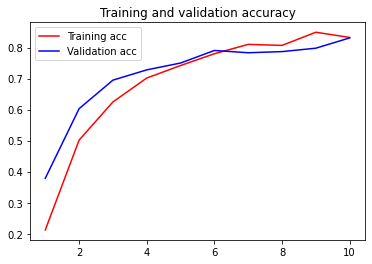

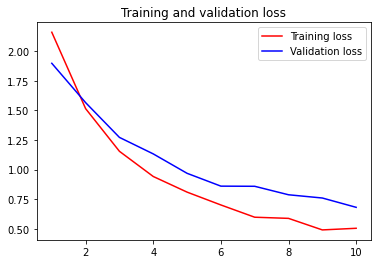

In [88]:
# 1- history training/validation accuracy over the epochs
# 2- history training/validation loss over the epochs
history_plot(history)

Save model

In [82]:
MobileNet_model.save(data_dir + "model_mobileNet.h5")

## Predictions

Get predictions with tests images: predict/real 

[[0.16249767 0.02689091 0.09182363 0.06568205 0.13415337 0.04790883
  0.15591462 0.03085085 0.2361854  0.04809266]]


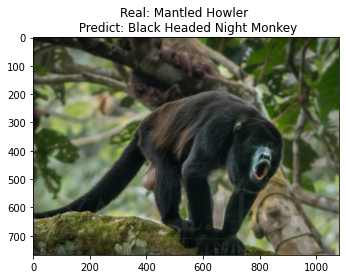

[[0.10229962 0.04724537 0.07570702 0.2148695  0.06266043 0.04500423
  0.13042209 0.04520433 0.24044074 0.03614676]]


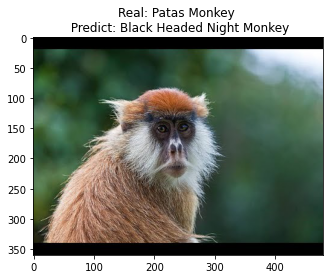

[[0.13761522 0.02668808 0.10833909 0.05956923 0.10623013 0.05285239
  0.15393586 0.02113833 0.2947672  0.03886449]]


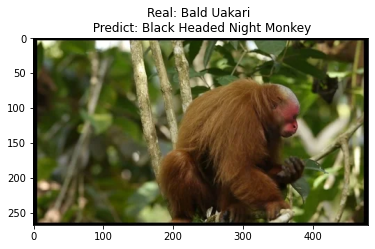

[[0.16876005 0.03837373 0.06642948 0.15571803 0.07935102 0.03808963
  0.131429   0.05702084 0.23221934 0.03260896]]


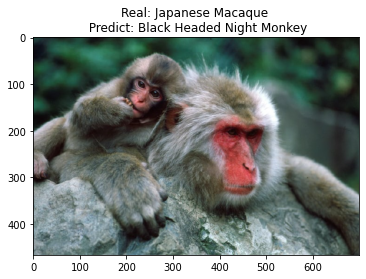

[[0.14112033 0.03761975 0.10103024 0.06158362 0.08790595 0.03891793
  0.1913694  0.04160203 0.26196837 0.0368824 ]]


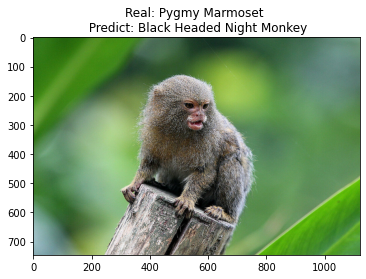

[[0.15463951 0.04338014 0.11214541 0.0571931  0.07970085 0.03234551
  0.17264925 0.02495335 0.29219517 0.03079769]]


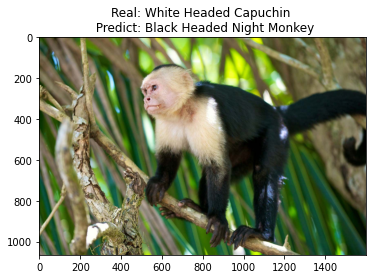

[[0.14948735 0.02674033 0.07055619 0.07281244 0.12809515 0.05029852
  0.19316489 0.04147135 0.22364786 0.04372595]]


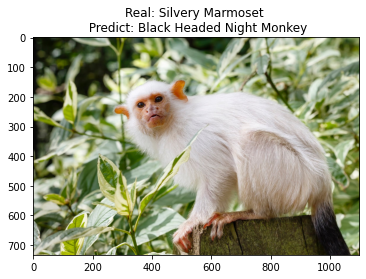

[[0.15212888 0.04975681 0.19716138 0.12869044 0.13731182 0.07764248
  0.03029983 0.04749861 0.08948106 0.09002873]]


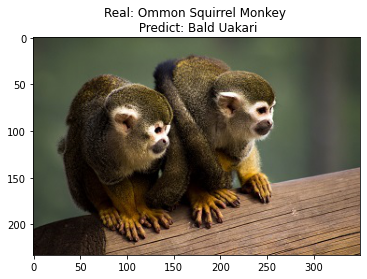

[[0.14664924 0.03541204 0.13151053 0.11464593 0.12916355 0.05455751
  0.10328479 0.04175049 0.19370212 0.04932382]]


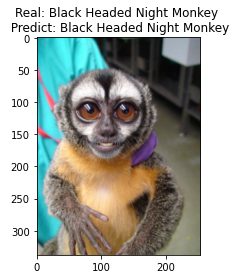

[[0.13450013 0.03544937 0.11589488 0.10762694 0.13674662 0.04399695
  0.12537797 0.05856209 0.16649917 0.0753459 ]]


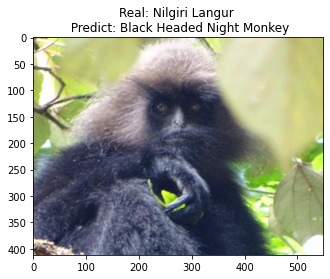

In [87]:
import io
import requests
from PIL import Image

for (i,label) in enumerate(test_labels):
    # img = load_img(img_name,target_size=(224,224))
    response = requests.get(test_images[i])
    img = Image.open(io.BytesIO(response.content))
    image = tf.keras.utils.img_to_array(img.resize((224, 224)))
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    prediction=MobileNet_model.predict(image)
    print(prediction)
    output = np.argmax(prediction)
        
    plt.title("Real: {} \n Predict: {}".format(monkey_speciets_type[i], monkey_speciets_type[output]))
    plt.imshow(img)
    plt.show()